In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy import table

from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy import wcs
from astropy.wcs import WCS

from astroquery.vizier import Vizier
from astroquery.svo_fps import SvoFps

import photutils

import tqdm

from spectral_cube import SpectralCube
import os
import glob

# load up ALMA-IMF metadata
import sys
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis/')
from spectralindex import prefixes
import spitzer_plots
from spitzer_plots import show_fov_on_spitzer, contour_levels, get_spitzer_data

from sedfitter.filter import Filter
from sedfitter.extinction import Extinction
from sedfitter.source import Source
from sedfitter import fit, Fitter

from dust_extinction.parameter_averages import F19

%matplotlib inline
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['font.size'] = 16

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
geometries = ["s---s-i", "s---smi", "sp--s-i", "sp--h-i", "s---smi", "s-p-smi",
              "s-p-hmi", "s-pbsmi", "s-pbhmi", "s-u-smi", "s-u-hmi", "s-ubsmi",
              "s-ubhmi", "spu-smi", "spu-hmi", "spubsmi", "spubhmi", "sp--hmi", "sp--smi"]

In [3]:
spicy_row_numbers = pd.read_csv('/blue/adamginsburg/morganhimes/spicy_rownumbers.txt', delimiter=' ')
print(spicy_row_numbers)

    SPICYID  ROWNUM ALMA_1mm ALMA_3mm
0     73642      82        F        F
1     73650      43        F        F
2     73653      83        F        F
3     73659      78        T        F
4     73662      74        F        F
5     73668      73        F        F
6     73673      39        F        F
7     73675      79        F        F
8     73676      80        F        T
9     73678      76        F        F
10    73683      75        F        F
11    73695      77        F        F
12    73698      81        F        F


In [4]:
### Change this part based on what source you are looking at 
SPICYID = spicy_row_numbers['SPICYID'][0]
row_num = spicy_row_numbers['ROWNUM'][0]
print(row_num, SPICYID)

82 73642


In [5]:
tbl = Table.read('/blue/adamginsburg/adamginsburg/ALMA_IMF/SPICY_ALMAIMF/SPICY_withAddOns.fits')
tbl['ALMA-IMF_1mm_eflux'] = tbl['ALMA-IMF_1mm_eflux'].quantity.to(u.mJy/u.beam)
tbl['ALMA-IMF_3mm_eflux'] = tbl['ALMA-IMF_3mm_eflux'].quantity.to(u.mJy/u.beam)
tbl['ALMA-IMF_1mm_flux'] = tbl['ALMA-IMF_1mm_flux'].quantity.to(u.mJy/u.beam)
tbl['ALMA-IMF_3mm_flux'] = tbl['ALMA-IMF_3mm_flux'].quantity.to(u.mJy/u.beam)
#tbl = Table.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/May2021Release/SPICY_withAddOns.fits')
from table_loading import fit_a_source, filternames, get_fitter, get_data_to_fit, make_extinction
all_filters = filternames + ["ALMA-IMF_1mm", "ALMA-IMF_3mm"]

#Removed aperture_size keyword
fitter = {geom: get_fitter(geometry=geom,
               distance_range=[4.3, 4.7]*u.kpc,
               robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/',
               filters=all_filters, extinction=make_extinction(),
               av_range=[9,40]) for geom in geometries}

data, error, valid = get_data_to_fit(rownumber=row_num, tbl=tbl, filters=all_filters)

#fitinfo = fit_a_source(data, error, valid, fitter=fitter)

#fitinfo = fit_a_source(data, error, valid, fitter=fitter[geom])

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---s-i
   Log[d] stepping     :  0.02
   Number of distances :  3

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Y.fits


   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Z.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.J.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.H.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Ks.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I1.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I2.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I3.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I4.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s--

In [6]:
fitinfo = {geom: fit_a_source(data, error, valid, fitter=fitter[geom]) for geom in geometries}

In [7]:
fitinfo

{'s---s-i': <sedfitter.fit_info.FitInfo at 0x2b59d21225c0>,
 's---smi': <sedfitter.fit_info.FitInfo at 0x2b59d2122b38>,
 'sp--s-i': <sedfitter.fit_info.FitInfo at 0x2b59d27e09b0>,
 'sp--h-i': <sedfitter.fit_info.FitInfo at 0x2b59d2122ac8>,
 's-p-smi': <sedfitter.fit_info.FitInfo at 0x2b59d2122780>,
 's-p-hmi': <sedfitter.fit_info.FitInfo at 0x2b59d2122cf8>,
 's-pbsmi': <sedfitter.fit_info.FitInfo at 0x2b59d2122e48>,
 's-pbhmi': <sedfitter.fit_info.FitInfo at 0x2b59d2122f60>,
 's-u-smi': <sedfitter.fit_info.FitInfo at 0x2b59d2122dd8>,
 's-u-hmi': <sedfitter.fit_info.FitInfo at 0x2b5983d180f0>,
 's-ubsmi': <sedfitter.fit_info.FitInfo at 0x2b59d212f0f0>,
 's-ubhmi': <sedfitter.fit_info.FitInfo at 0x2b59d212f1d0>,
 'spu-smi': <sedfitter.fit_info.FitInfo at 0x2b59d212f320>,
 'spu-hmi': <sedfitter.fit_info.FitInfo at 0x2b59d212f278>,
 'spubsmi': <sedfitter.fit_info.FitInfo at 0x2b59d212f9e8>,
 'spubhmi': <sedfitter.fit_info.FitInfo at 0x2b59d212f550>,
 'sp--hmi': <sedfitter.fit_info.FitInfo 

In [8]:
filtercurves = {filtername: SvoFps.get_transmission_data(filtername) for filtername in filternames}

wavelengths = [np.average(filtercurves[filtername]['Wavelength'],
                              weights=filtercurves[filtername]['Transmission'])
                  for filtername in filternames]
wavelength_dict = {filtername: np.average(filtercurves[filtername]['Wavelength'],
                                              weights=filtercurves[filtername]['Transmission'])*u.AA
                       for filtername in filternames}

In [9]:
all_filters

['Paranal/VISTA.Y',
 'Paranal/VISTA.Z',
 'Paranal/VISTA.J',
 'Paranal/VISTA.H',
 'Paranal/VISTA.Ks',
 'Spitzer/IRAC.I1',
 'Spitzer/IRAC.I2',
 'Spitzer/IRAC.I3',
 'Spitzer/IRAC.I4',
 'Spitzer/MIPS.24mu',
 'Herschel/Pacs.blue',
 'Herschel/Pacs.red',
 'Herschel/SPIRE.PSW',
 'Herschel/SPIRE.PMW',
 'Herschel/SPIRE.PLW',
 'ALMA-IMF_1mm',
 'ALMA-IMF_3mm']

In [10]:
source = Source()

source.valid = valid
source.flux = data
source.error =  error

In [11]:
tbl[row_num]

SPICY,ra,dec,l,b,p1,p2,p3,class,silicate,pah,alpha,alpha_8,alpha_24,alpha_w4,env,group,var,nr,r,sigmar,skewnessr,Spitzer,mag3_6,e_mag3_6,mag4_5,e_mag4_5,mag5_8,e_mag5_8,mag8_0,e_mag8_0,csf,m3_6,m4_5,m5_8,m8_0,2MASS,UKIDSS,VIRAC,GaiaDR2,MIPS,AllWISE,ZTFDR3,in_ALMAIMF,ALMAIMF_FIELDID,70,160,250,350,500,Spitzer/MIPS.24mu_flux,Spitzer/MIPS.24mu_eflux,M24_flux_uplim,RA_ICRS,DE_ICRS,Ksmag,KsEll,pm,e_pm,pmRA,e_pmRA,pmDE,e_pmDE,Nep,flgrel,Zmag,Zell,Ymag,Yell,Jmag,Jell,Hmag,Hell,Zdetflg,Ydetflg,Jdetflg,Hdetflg,ALMA-IMF_3mm_flux,ALMA-IMF_3mm_eflux,ALMA-IMF_1mm_flux,ALMA-IMF_1mm_eflux,Paranal/VISTA.Y_flux,Paranal/VISTA.Y_eflux,Paranal/VISTA.Z_flux,Paranal/VISTA.Z_eflux,Paranal/VISTA.J_flux,Paranal/VISTA.J_eflux,Paranal/VISTA.H_flux,Paranal/VISTA.H_eflux,Paranal/VISTA.Ks_flux,Paranal/VISTA.Ks_eflux,Spitzer/IRAC.I1_flux,Spitzer/IRAC.I1_eflux,Spitzer/IRAC.I2_flux,Spitzer/IRAC.I2_eflux,Spitzer/IRAC.I3_flux,Spitzer/IRAC.I3_eflux,Spitzer/IRAC.I4_flux,Spitzer/IRAC.I4_eflux,Herschel/Pacs.blue_eflux,Herschel/Pacs.red_eflux,Herschel/SPIRE.PSW_eflux,Herschel/SPIRE.PMW_eflux,Herschel/SPIRE.PLW_eflux,Herschel/Pacs.blue_flux,Herschel/Pacs.red_flux,Herschel/SPIRE.PSW_flux,Herschel/SPIRE.PMW_flux,Herschel/SPIRE.PLW_flux
,deg,deg,deg,deg,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,Jy / pix,Jy / pix,MJy / sr,MJy / sr,MJy / sr,mJy,mJy,MJy / sr,deg,deg,mag,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,mag,,mag,,mag,,mag,,,,,,mJy / beam,mJy / beam,mJy / beam,mJy / beam,,,,,,,,,,,mJy,mag mJy,mJy,mag mJy,,mag,,mag,mJy,mJy,mJy,mJy,mJy,,,,,
int64,float64,float64,float64,float64,float32,float32,float32,bytes9,bool,bool,float64,float64,float64,float64,bytes7,bytes10,int16,int16,float64,float64,float64,bytes26,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,bytes18,bytes19,int32,int64,bytes18,bytes20,int64,bool,bytes8,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,int16,uint8,float64,float32,float64,float32,float32,float32,float64,float32,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
73642,271.576385,-21.618896,8.673839,-0.350408,--,--,0.93,uncertain,False,False,--,--,--,--,EnvIII,G8.7-0.3,--,--,--,--,--,SSTGLMC G008.6738-00.3504,10.825,0.064,9.814,0.073,9.117,0.166,--,--,0,3,4,3,0,,,206172820,--,,J180618.30-213708.5,--,True,G008,1.115453756812632,3.741185599705438,11824.778268001402,4633.310050425159,2122.0290014204234,--,--,--,271.576461,-21.618870,14.429,0.1,5.45,0.73,5.02,0.72,2.134,0.774,210,1,--,--,--,--,--,--,--,--,1,1,1,1,nan,0.09742119164913868,nan,0.4115273830446027,--,--,--,--,--,--,--,--,1.1328994,0.1,12.966661,0.76134527,21.249166,1.4231092,25.675962,3.9102838,--,--,1115.453756812632,3741.185599705438,85804.46979993094,56583.19667874292,50868.78981189679,--,--,--,--,--


In [13]:
from table_loading import Source, wavelength_dict
extinction = make_extinction()
from sedfitter.sed import SEDCube
robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/'

for geom in geometries:
    model_dir = f'{robitaille_modeldir}/{geom}'
    sedcube = SEDCube.read(f"{model_dir}/flux.fits",)

wavelengths = u.Quantity([wavelength_dict[fn] for fn in all_filters], u.um)
apnum = np.argmin(np.abs((3*u.arcsec * 2*u.kpc).to(u.au, u.dimensionless_angles()) - sedcube.apertures))
distance = 2*u.kpc

In [14]:
# this is really clunky, but it works
pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s---s-i_augmented.fits')
pars_s_s_i = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s---s-i_augmented.fits')
pars_sp_s_i = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--s-i_augmented.fits')
pars_sp_h_i = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--h-i_augmented.fits')
pars_s_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s---smi_augmented.fits')
pars_sp_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--smi_augmented.fits')
pars_sp_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--hmi_augmented.fits')
pars_s_p_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-p-smi_augmented.fits')
pars_s_p_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-p-hmi_augmented.fits')
pars_s_pbsmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-pbsmi_augmented.fits')
pars_s_pbhmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-pbhmi_augmented.fits')
pars_s_u_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-u-smi_augmented.fits')
pars_s_u_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-u-hmi_augmented.fits')
pars_s_ubsmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-ubsmi_augmented.fits')
pars_s_ubhmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-ubhmi_augmented.fits')
pars_spu_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spu-smi_augmented.fits')
pars_spu_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spu-hmi_augmented.fits')
pars_spubsmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spubsmi_augmented.fits')
pars_spubhmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spubhmi_augmented.fits')

pars_all = [pars_s_s_i, pars_sp_s_i, pars_sp_h_i, pars_s_smi, pars_sp_smi, pars_sp_hmi, pars_s_p_smi, pars_s_p_hmi, pars_s_pbsmi, pars_s_pbhmi, pars_s_u_smi, pars_s_u_hmi, pars_s_ubsmi, pars_s_ubhmi, pars_spu_smi, pars_spu_hmi, pars_spubsmi, pars_spubhmi]
bestfits_all = [fitinfo["s---s-i"], fitinfo["sp--s-i"], fitinfo["sp--h-i"], fitinfo["s---smi"], fitinfo["sp--smi"], fitinfo["sp--hmi"], fitinfo["s-p-smi"], fitinfo["s-p-hmi"], fitinfo["s-pbsmi"], fitinfo["s-pbhmi"], fitinfo["s-u-smi"], fitinfo["s-u-hmi"], fitinfo["s-ubsmi"], fitinfo["s-ubhmi"], fitinfo["spu-smi"], fitinfo["spu-hmi"], fitinfo["spubsmi"], fitinfo["spubhmi"]]

In [22]:
best_geometries = []

for geom in geometries:
    fitinfo3 = fitinfo[geom]
    
    model_dir = f'{robitaille_modeldir}/{geom}'
    sedcube = SEDCube.read(f"{model_dir}/flux.fits",)
    
    index = np.nanargmin(fitinfo3.chi2)
    modelname = fitinfo3.model_name[index]
    
    smallest_chi2 = np.nanmin(fitinfo3.chi2)
    
    data = (geom, modelname, smallest_chi2)
    
    best_geometries.append(data)
    
from operator import itemgetter
best_geometries.sort(key=itemgetter(2))

print(best_geometries)

geometries_bestfits = []
model_ids = []
chi2_values = []

for i in range(5):
    geometries_bestfits.append(best_geometries[i][0])
    model_ids.append(best_geometries[i][1])
    chi2_values.append(best_geometries[i][2])
    
print(geometries_bestfits)
print(model_ids)
print(chi2_values)


chi2limit = 3*(np.max(chi2_values))
print(chi2limit)

[('sp--h-i', 'nylV3lK5_09', <Quantity 0.16564889>), ('spubhmi', 'kA8hcPgz_06', <Quantity 0.2876323>), ('sp--hmi', 'ygIQ6oRy_09', <Quantity 0.28800971>), ('s-p-smi', 'QEdlq4AK_01', <Quantity 0.32398464>), ('s-pbsmi', 'HoaCaCyq_08', <Quantity 0.46700605>), ('s-pbhmi', 'hZil217S_07', <Quantity 0.50452244>), ('s-u-smi', 'YAe9Uxw7_06', <Quantity 0.75808504>), ('spu-hmi', 'q9bB8CqT_01', <Quantity 0.97029725>), ('sp--s-i', '2ws2gcEa_04', <Quantity 1.10305437>), ('s-ubsmi', 'K1WVEMjx_01', <Quantity 1.12336362>), ('spubsmi', 'o5FjgHwD_07', <Quantity 1.19173347>), ('spu-smi', 'bxi3SJz4_08', <Quantity 1.20574891>), ('sp--smi', 'p2nMVdNC_08', <Quantity 1.72354331>), ('s-ubhmi', '80CIB7tJ_03', <Quantity 2.48784171>), ('s-p-hmi', 'mscz9Cgo_01', <Quantity 3.16737693>), ('s-u-hmi', 'cqSdgjwk_03', <Quantity 7.51810388>), ('s---s-i', 'qRRf0SOP_01', <Quantity 81.35192732>), ('s---smi', 'KmRNS7hG_01', <Quantity 82.76200525>), ('s---smi', 'KmRNS7hG_01', <Quantity 82.76200525>)]
['sp--h-i', 'spubhmi', 'sp--

In [23]:
# establish fitinfo for all geometries
if "s---s-i" in geometries_bestfits:
    thisfitinfo0 = bestfits_all[0]
    thispars0 = pars_all[0]
    selection0 = thisfitinfo0.chi2 < np.nanmin(thisfitinfo0.chi2) + chi2limit
    thispars0[thisfitinfo0.model_id[selection0]].show_in_notebook()
    print(thispars0[thisfitinfo0.model_id[selection0]])
else: 
    print("s--s-i didn't make the cut.")

if "sp--s-i" in geometries_bestfits:
    thisfitinfo1 = bestfits_all[1]
    thispars1 = pars_all[1]
    selection1 = thisfitinfo1.chi2 < np.nanmin(thisfitinfo1.chi2) + chi2limit
    thispars1[thisfitinfo1.model_id[selection1]].show_in_notebook()
    print(thispars1[thisfitinfo1.model_id[selection1]])
else: 
    print("sp-s-i didn't make the cut.")
    
if "sp--h-i" in geometries_bestfits:
    thisfitinfo2 = bestfits_all[2]
    thispars2 = pars_all[2]
    selection2 = thisfitinfo2.chi2 < np.nanmin(thisfitinfo2.chi2) + chi2limit
    thispars2[thisfitinfo2.model_id[selection2]].show_in_notebook()
    print(thispars2[thisfitinfo2.model_id[selection2]])
else: 
    print("sp-h-i didn't make the cut.")
    
if "s---smi" in geometries_bestfits:
    thisfitinfo3 = bestfits_all[3]
    thispars3 = pars_all[3]
    selection3 = thisfitinfo3.chi2 < np.nanmin(thisfitinfo3.chi2) + chi2limit
    thispars3[thisfitinfo3.model_id[selection3]].show_in_notebook()
    print(thispars3[thisfitinfo3.model_id[selection3]])
else: 
    print("s---smi didn't make the cut.")
    
if "sp--smi" in geometries_bestfits:
    thisfitinfo4 = bestfits_all[4]
    thispars4 = pars_all[4]
    selection4 = thisfitinfo4.chi2 < np.nanmin(thisfitinfo4.chi2) + chi2limit
    thispars4[thisfitinfo4.model_id[selection4]].show_in_notebook()
    print(thispars4[thisfitinfo4.model_id[selection4]])
else: 
    print("sp--smi didn't make the cut.")
    
if "sp--hmi" in geometries_bestfits:
    thisfitinfo5 = bestfits_all[5]
    thispars5 = pars_all[5]
    selection5 = thisfitinfo5.chi2 < np.nanmin(thisfitinfo5.chi2) + chi2limit
    thispars5[thisfitinfo5.model_id[selection5]].show_in_notebook()
    print(thispars5[thisfitinfo5.model_id[selection5]])
else: 
    print("sp--hmi didn't make the cut.")
    
if "s-p-smi" in geometries_bestfits:
    thisfitinfo6 = bestfits_all[6]
    thispars6 = pars_all[6]
    selection6 = thisfitinfo6.chi2 < np.nanmin(thisfitinfo6.chi2) + chi2limit
    thispars6[thisfitinfo6.model_id[selection6]].show_in_notebook()
    print(thispars6[thisfitinfo6.model_id[selection6]])
else: 
    print("s-p-smi didn't make the cut.")
    
if "s-p-hmi" in geometries_bestfits:
    thisfitinfo7 = bestfits_all[7]
    thispars7 = pars_all[7]
    selection7 = thisfitinfo7.chi2 < np.nanmin(thisfitinfo7.chi2) + chi2limit
    thispars7[thisfitinfo7.model_id[selection7]].show_in_notebook()
    print(thispars7[thisfitinfo7.model_id[selection7]])
else: 
    print("s-p-hmi didn't make the cut.")
    
if "s-pbsmi" in geometries_bestfits:
    thisfitinfo8 = bestfits_all[8]
    thispars8 = pars_all[8]
    selection8 = thisfitinfo8.chi2 < np.nanmin(thisfitinfo8.chi2) + chi2limit
    thispars8[thisfitinfo8.model_id[selection8]].show_in_notebook()
    print(thispars8[thisfitinfo8.model_id[selection8]])
else: 
    print("s-pbsmi didn't make the cut.")

if "s-pbhmi" in geometries_bestfits:
    thisfitinfo9 = bestfits_all[9]
    thispars9 = pars_all[9]
    selection9 = thisfitinfo9.chi2 < np.nanmin(thisfitinfo9.chi2) + chi2limit
    thispars9[thisfitinfo9.model_id[selection9]].show_in_notebook()
    print(thispars9[thisfitinfo9.model_id[selection9]])
else: 
    print("s-pbhmi didn't make the cut.")
    
if "s-u-smi" in geometries_bestfits:
    thisfitinfo10 = bestfits_all[10]
    thispars10 = pars_all[10]
    selection10 = thisfitinfo10.chi2 < np.nanmin(thisfitinfo10.chi2) + chi2limit
    thispars10[thisfitinfo10.model_id[selection10]].show_in_notebook()
    print(thispars10[thisfitinfo10.model_id[selection10]])
else: 
    print("s-u-smi didn't make the cut.")
    
if "s-u-hmi" in geometries_bestfits:
    thisfitinfo11 = bestfits_all[11]
    thispars11 = pars_all[11]
    selection11 = thisfitinfo11.chi2 < np.nanmin(thisfitinfo11.chi2) + chi2limit
    thispars11[thisfitinfo11.model_id[selection11]].show_in_notebook()
    print(thispars11[thisfitinfo11.model_id[selection11]])
else: 
    print("s-u-hmi didn't make the cut.")
    
if "s-ubsmi" in geometries_bestfits:
    thisfitinfo12 = bestfits_all[12]
    thispars12 = pars_all[12]
    selection12 = thisfitinfo12.chi2 < np.nanmin(thisfitinfo12.chi2) + chi2limit
    thispars12[thisfitinfo12.model_id[selection12]].show_in_notebook()
    print(thispars12[thisfitinfo12.model_id[selection12]])
else: 
    print("s-ubsmi didn't make the cut.")
    
if "s-ubhmi" in geometries_bestfits:
    thisfitinfo13 = bestfits_all[13]
    thispars13 = pars_all[13]
    selection13 = thisfitinfo13.chi2 < np.nanmin(thisfitinfo13.chi2) + chi2limit
    thispars13[thisfitinfo13.model_id[selection13]].show_in_notebook()
    print(thispars13[thisfitinfo13.model_id[selection13]])
else: 
    print("s-ubhmi didn't make the cut.")
    
if "spu-smi" in geometries_bestfits:
    thisfitinfo14 = bestfits_all[14]
    thispars14 = pars_all[14]
    selection14 = thisfitinfo14.chi2 < np.nanmin(thisfitinfo14.chi2) + chi2limit
    thispars14[thisfitinfo14.model_id[selection14]].show_in_notebook()
    print(thispars14[thisfitinfo14.model_id[selection14]])
else: 
    print("spu-smi didn't make the cut.")

if "spu-hmi" in geometries_bestfits:
    thisfitinfo15 = bestfits_all[15]
    thispars15 = pars_all[15]
    selection15 = thisfitinfo15.chi2 < np.nanmin(thisfitinfo15.chi2) + chi2limit
    thispars15[thisfitinfo15.model_id[selection15]].show_in_notebook()
    print(thispars15[thisfitinfo15.model_id[selection15]])
else: 
    print("spu-hmi didn't make the cut.")
    
if "spubsmi" in geometries_bestfits:
    thisfitinfo16 = bestfits_all[16]
    thispars16 = pars_all[16]
    selection16 = thisfitinfo16.chi2 < np.nanmin(thisfitinfo16.chi2) + chi2limit
    thispars16[thisfitinfo16.model_id[selection16]].show_in_notebook()
    print(thispars16[thisfitinfo16.model_id[selection16]])
else: 
    print("spubsmi didn't make the cut.")
    
if "spubhmi" in geometries_bestfits:
    thisfitinfo17 = bestfits_all[17]
    thispars17 = pars_all[17]
    selection17 = thisfitinfo17.chi2 < np.nanmin(thisfitinfo17.chi2) + chi2limit
    thispars17[thisfitinfo17.model_id[selection17]].show_in_notebook()
    print(thispars17[thisfitinfo17.model_id[selection17]])
else: 
    print("spubhmi didn't make the cut.")

s--s-i didn't make the cut.
sp-s-i didn't make the cut.
 MODEL_NAME star.radius ...    Disk Toomre Q    
                        ...                     
----------- ----------- ... --------------------
nylV3lK5_09       5.206 ...    6.127329188796084
lzg7qlxf_02       1.638 ...   0.1003420379145491
LJMlq31Y_06       3.898 ...  0.26957437903163683
K9sPA7XG_02        5.25 ...  0.00935057848120878
K9sPA7XG_03        5.25 ...  0.00935057848120878
lzg7qlxf_03       1.638 ...   0.1003420379145491
0dQd0hvU_06       26.44 ... 0.013440446128312999
LJMlq31Y_07       3.898 ...  0.26957437903163683
LJMlq31Y_03       3.898 ...  0.26957437903163683
LJMlq31Y_04       3.898 ...  0.26957437903163683
lzg7qlxf_04       1.638 ...   0.1003420379145491
I0X5bXpN_03       2.424 ... 0.009753855399838723
lzg7qlxf_05       1.638 ...   0.1003420379145491
LJMlq31Y_02       3.898 ...  0.26957437903163683
LJMlq31Y_05       3.898 ...  0.26957437903163683
w908MGe0_07       41.16 ... 0.057227197789933903
lzg7qlxf_06  

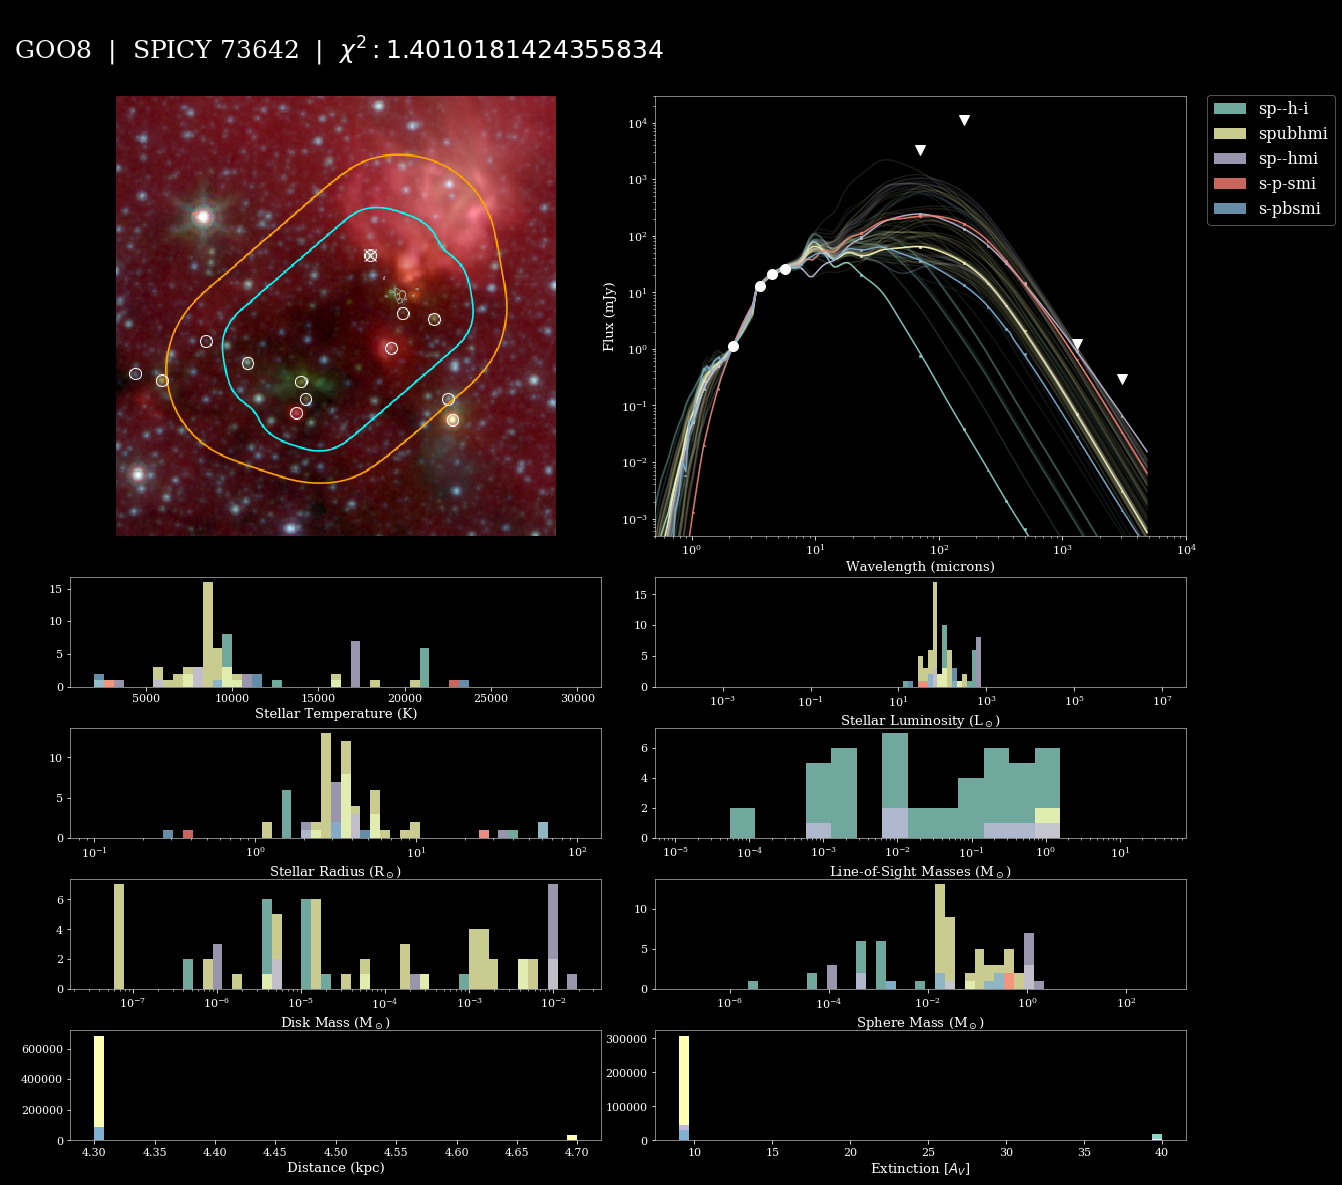

In [24]:
bestfits_source = fitinfo
geometries_selection = geometries_bestfits

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

from astropy import units as u
import sedfitter
from sedfitter.sed import SEDCube
from astropy.table import Table

import table_loading

def datafunction(geom, deltachi2lim, bestfits):
    pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geom}_augmented.fits')
    fitinfo = bestfits[geom]
    selection = fitinfo.chi2 < np.nanmin(fitinfo.chi2) + deltachi2lim
    data = pars[fitinfo.model_id[selection]]
    return pars, data

def binsfunction(param, kind, binsnum, deltachi2lim, geometries, bestfits, massnum=9):
    # note: the massnum indicates an index for aperture size, and is used in the
    # parameters which involve multiple aperture sizes to select just one. you'll
    # need to find out what your massnum= is if you use this.

    datamin = []
    datamax = []
    for geom in geometries:
        pars, data = datafunction(geom, deltachi2lim, bestfits)
        if param in pars.keys():
            if param == "Line-of-Sight Masses":
                dataparam = data[param]
                datamin.append(dataparam[massnum].min())
                datamax.append(dataparam[massnum].max())
            elif param == "Sphere Masses":
                dataparam = data[param]
                datamin.append(dataparam[massnum].min())
                datamax.append(dataparam[massnum].max())
            else:
                datamin.append(data[param].min())
                datamax.append(data[param].max())

    # just some idiot-proofing because i ran into a problem with this
    for x in datamin:
        if x == 0:
            datamin.remove(x)

    for x in datamax:
        if x == 0:
            datamax.remove(x)

    if kind == 'log':
        binsmin = np.log10(min(datamin))
        binsmax = np.log10(max(datamax))
        bins = np.logspace(binsmin, binsmax, binsnum)

    if kind == 'lin':
        binsmin = min(datamin)
        binsmax = max(datamax)
        bins = np.linspace(binsmin, binsmax, binsnum)

    if kind == 'geom':
        binsmin = min(datamin)
        binsmax = max(datamax)
        bins = np.geomspace(binsmin, binsmax, binsnum)

    return bins

def plot_fit(bestfits_source, geometries_selection,
        deltachi2limit,
        extinction=table_loading.make_extinction(),
        show_per_aperture=True,
        default_aperture=3*u.arcsec,
        robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/', show_all_models=True, alpha_allmodels=0.1,):

    # Setting up the plot surface
    basefig = plt.figure(figsize=(20, 22))
    gs = GridSpec(nrows=6, ncols=2, height_ratios=[4,1,1,1,1,1], hspace=0.25, wspace=0.1)

    # --------------------------------

    # Best fits plot
    ax0 = basefig.add_subplot(gs[0, 1])
    #wavelengths = u.Quantity([wavelength_dict[fn] for fn in all_filters], u.um)
    fitinfo = bestfits_source[geometries_selection[0]]
    source = fitinfo.source
    valid = source.valid
    wavelengths = u.Quantity([x['wav'] for x in fitinfo.meta.filters], u.um)
    apertures = u.Quantity([x['aperture_arcsec'] for x in fitinfo.meta.filters], u.arcsec)
    ax0.plot(wavelengths.value[valid==3], source.flux[valid==3], linestyle='none', color='w', marker='v', markersize=10)
    ax0.errorbar(wavelengths.value[valid==1], source.flux[valid==1], yerr=source.error[valid==1], linestyle='none', color='w', marker='o', markersize=10)

    distance = (10**fitinfo.sc * u.kpc).mean()
    
    for geom in geometries_selection:

        fitinfo = bestfits_source[geom]

        model_dir = f'{robitaille_modeldir}/{geom}'
        sedcube = SEDCube.read(f"{model_dir}/flux.fits",)

        index = np.nanargmin(fitinfo.chi2)
        
        distance = (10**fitinfo.sc[index] * u.kpc)

        modelname = fitinfo.model_name[index]
        sed = sedcube.get_sed(modelname)

        apnum = np.argmin(np.abs((default_aperture * distance).to(u.au, u.dimensionless_angles()) - sedcube.apertures))
        
        # https://github.com/astrofrog/sedfitter/blob/41dee15bdd069132b7c2fc0f71c4e2741194c83e/sedfitter/sed/sed.py#L64
        distance_scale = (1*u.kpc/distance)**2

        # https://github.com/astrofrog/sedfitter/blob/41dee15bdd069132b7c2fc0f71c4e2741194c83e/sedfitter/sed/sed.py#L84
        av_scale = 10**((fitinfo.av[index] * extinction.get_av(sed.wav)))

        line, = ax0.plot(sedcube.wav,
                 sed.flux[apnum] * distance_scale * av_scale,
                 label=geom, alpha=0.9)
        
        indices = fitinfo.chi2 < (deltachi2limit + np.nanmin(fitinfo.chi2))
        
        if show_all_models and any(indices):
            dist_scs = ((1*u.kpc)/(10**fitinfo.sc[indices] * u.kpc))**2
            mods = np.array([sedcube.get_sed(modelname).flux[apnum] for modelname in fitinfo.model_name[indices]])
            av_scales = 10**((fitinfo.av[indices][:,None] * extinction.get_av(sed.wav)[None,:]))
            
            lines = ax0.plot(sedcube.wav,
                             (mods * dist_scs[:,None] * av_scales).T,
                             alpha=alpha_allmodels,
                             c=line.get_color())

        if show_per_aperture:
            apnums = np.array([
                np.argmin(np.abs((apsize * distance).to(u.au, u.dimensionless_angles()) - sedcube.apertures))
                for apsize in apertures])
            wlids = np.array([
                np.argmin(np.abs(ww - sedcube.wav)) for ww in wavelengths])
            flux = np.array([sed.flux[apn, wavid].value for apn, wavid in zip(apnums, wlids)])
            av_scale_conv = 10**((fitinfo.av[index] * extinction.get_av(wavelengths)))
            flux = flux * distance_scale * av_scale_conv
            ax0.scatter(wavelengths, flux, marker='s', s=apertures.value, c=line.get_color())
            

    ax0.loglog()
    ax0.set_xlabel('Wavelength (microns)')
    ax0.set_ylabel("Flux (mJy)")
    ax0.set_xlim(0.5,1e4)
    ax0.set_ylim(5e-4,3e4)

    # --------------------------------

    # ax1 = stellar temperature
    # ax2 = model luminosity

    # ax3 = stellar radius
    # ax4 = line-of-sight mass

    # ax5 = disk mass
    # ax6 = sphere mass

    ax1 = basefig.add_subplot(gs[1, 0])
    ax2 = basefig.add_subplot(gs[1, 1])
    ax3 = basefig.add_subplot(gs[2, 0])
    ax4 = basefig.add_subplot(gs[2, 1])
    ax5 = basefig.add_subplot(gs[3, 0])
    ax6 = basefig.add_subplot(gs[3, 1])
    ax7 = basefig.add_subplot(gs[4, 0])
    ax8 = basefig.add_subplot(gs[4, 1])

    
    histalpha = 0.8
    lognum = 50
    linnum = 50

    #tempbins = binsfunction('star.temperature', 'lin', linnum, chi2limit, geometries_selection, bestfits_source)
    tempbins = np.linspace(2000, 30000, 50)
    #lumbins = binsfunction('Model Luminosity', 'log', lognum, chi2limit, geometries_selection, bestfits_source)
    lumbins = np.logspace(-4,7,100)
    #radbins = binsfunction('star.radius', 'log', lognum, chi2limit, geometries_selection, bestfits_source)
    radbins = np.geomspace(0.1, 100, 50)
    losbins = binsfunction('Line-of-Sight Masses', 'log', 20, deltachi2limit, geometries_selection, bestfits_source, 0)
    try:
        dscbins = binsfunction('disk.mass', 'log', lognum, deltachi2limit, geometries_selection, bestfits_source)
    except ValueError:
        # this is OK; some models don't have disks
        pass
    sphbins = binsfunction('Sphere Masses', 'log', 50, deltachi2limit, geometries_selection, bestfits_source, 0)

    # index values used above and below for mass-related parameters should, i think, be the same as your
    # massnum index, which again has to do with aperture sizes

    for geom in geometries_selection:
        pars, data = datafunction(geom, deltachi2limit, bestfits_source)

        if 'star.temperature' in pars.keys():
            ax1.hist(data['star.temperature'], bins=tempbins, alpha=histalpha, label=geom)

        if 'Model Luminosity' in pars.keys():
            ax2.hist(data['Model Luminosity'], bins=lumbins, alpha=histalpha, label=geom)

        if 'star.radius' in pars.keys():
            ax3.hist(data['star.radius'], bins=radbins, alpha=histalpha, label=geom)

        if 'Line-of-Sight Masses' in pars.keys():
            ax4.hist(data['Line-of-Sight Masses'][:,apnum], bins=losbins, alpha=histalpha, label=geom)

        if 'disk.mass' in pars.keys():
            ax5.hist(data['disk.mass'], bins=dscbins, alpha=histalpha, label=geom)

        if 'Sphere Masses' in pars.keys():
            ax6.hist(data['Sphere Masses'][:,apnum], bins=sphbins, alpha=histalpha, label=geom)

    for geom in geometries_bestfits:
        fitinfo = bestfits_source[geom]

        distances = 10**fitinfo.sc
        ax7.hist(distances, bins=np.linspace(distances.min(), distances.max()))

        ax8.hist(fitinfo.av, bins=np.linspace(np.nanmin(fitinfo.av), np.nanmax(fitinfo.av)))
    
            
    handles, labels = ax1.get_legend_handles_labels()
    ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.16,1.02))
    ax1.set_xlabel("Stellar Temperature (K)")
    ax2.set_xlabel("Stellar Luminosity (L$_\odot$)")
    ax3.set_xlabel("Stellar Radius (R$_\odot$)")
    ax4.set_xlabel("Line-of-Sight Masses (M$_\odot$)")
    ax5.set_xlabel("Disk Mass (M$_\odot$)")
    ax6.set_xlabel("Sphere Mass (M$_\odot$)")
    ax7.set_xlabel("Distance (kpc)")
    ax8.set_xlabel("Extinction [$A_V$]")

    _=ax2.semilogx()
    _=ax3.semilogx()
    _=ax4.semilogx()
    _=ax5.semilogx()
    _=ax6.semilogx()

    # --------------------------------

    # reading the saved image of the region with source location marked
    locfig = mpimg.imread(f'/home/morganhimes/figures/G008_{SPICYID}.png')

    # my image needs to be flipped
    locfig = np.flipud(locfig)

    ax9 = basefig.add_subplot(gs[0, 0])
    ax9.imshow(locfig)
    ttl = ax9.set_title(f'\n GOO8  |  SPICY {SPICYID}  |  ${{\chi^2}}: {chi2limit}$\n' , fontsize=25)
    ttl.set_position([.5, 1])
    ax9.axis([170,550,170,550])
    ax9.axis('off')
    
plot_fit(bestfits_source, geometries_selection,
        chi2limit,
        extinction=table_loading.make_extinction(),
        show_per_aperture=True,
        default_aperture=3*u.arcsec,
        robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/', show_all_models=True, alpha_allmodels=0.1)

In [25]:
from astropy.table import Table
import numpy as np

SOURCES = np.array([SPICYID, SPICYID, SPICYID, SPICYID, SPICYID])
GEOMETRIES = geometries_bestfits
MODEL_IDS = model_ids
CHI2_VALUES = chi2_values


tbl_source = Table([SOURCES, GEOMETRIES, MODEL_IDS, CHI2_VALUES],
             names=('SPICY ID', 'Geometries', 'Model IDs', 'Chi-squared'),
             meta={'SPICYID': SPICYID})

In [26]:
tbl_source

SPICY ID,Geometries,Model IDs,Chi-squared
int64,str7,str11,float64
73642,sp--h-i,nylV3lK5_09,0.16564889016268053
73642,spubhmi,kA8hcPgz_06,0.28763230280511176
73642,sp--hmi,ygIQ6oRy_09,0.28800971387276475
73642,s-p-smi,QEdlq4AK_01,0.3239846449001742
73642,s-pbsmi,HoaCaCyq_08,0.4670060474785278


In [28]:
# I opted to keep the method of initializing dummy and regular lists to avoid having to figure out a loop structure that would involve multiple loops inside another loop
star_temp_dummy = []
model_lum_dummy = []
star_rad_dummy = []
los_mass_dummy = []
disk_mass_dummy = []
sphere_mass_dummy = []

star_temperature = []
model_luminosity = []
star_radius = []
disk_mass = []

#for geom in geometries_selection:
for geom in geometries_bestfits:
        pars, data = datafunction(geom, chi2limit, bestfits_source)

        if 'star.temperature' in pars.keys():
            star_temp_dummy.append(data['star.temperature'])

        if 'Model Luminosity' in pars.keys():
            model_lum_dummy.append(data['Model Luminosity'])

        if 'star.radius' in pars.keys():
            star_rad_dummy.append(data['star.radius'])

        if 'Line-of-Sight Masses' in pars.keys():
            los_mass_dummy.append(data['Line-of-Sight Masses'][:,apnum])

        if 'disk.mass' in pars.keys():
            disk_mass_dummy.append(data['disk.mass'])

        if 'Sphere Masses' in pars.keys():
            sphere_mass_dummy.append(data['Sphere Masses'][:,apnum])
    
# Looping through to get the values for star temperature
# I’ve made an entirely new loop structure here. First I initialize a list that will store the length of each list in the star_temp_dummy array (since star_temp_dummy is an array of lists)
# Then, I loop through the range stored in each index of L_st_array. L_st_array[i] should correspond with star_temp_dummy[i] and the value stored in L_st_array[i] should be the range of ii for which we have to loop through star_temp_dummy[i][ii]. Then they are appended as normal to star_temperature
L_st_array = []  
for i in range (len(geometries_bestfits)):
    L = len(star_temp_dummy[i])
    L_st_array.append(L)
    for ii in range(L_st_array[i]):
        data_arr = star_temp_dummy[i][ii]
        star_temperature.append(data_arr)

# Model luminosity and star radius follow the same loop structure as star temp. The next change to the loop occurs with disk mass
## Looping through to get the values for model luminosity
L_ml_array = []  
for i in range (len(geometries_bestfits)):
    L = len(model_lum_dummy[i])
    L_ml_array.append(L)
    for ii in range(L_ml_array[i]):
        data_arr = model_lum_dummy[i][ii]
        model_luminosity.append(data_arr)

## Looping through to get the values for star radius
L_sr_array = []  
for i in range (len(geometries_bestfits)):
    L = len(star_rad_dummy[i])
    L_sr_array.append(L)
    for ii in range(L_sr_array[i]):
        data_arr = star_rad_dummy[i][ii]
        star_radius.append(data_arr)
    
# With LOS and sphere masses, we realized np.concatenate is enough to unravel the columns stored, so this is greatly simplified from before
# Flattening the Line of Sight Masses
los_mass = np.concatenate(los_mass_dummy)

# Disk mass is more complicated because not all of the models have disk masses associated with them. We use the same length list set up as before but now I initialize another list where I will store the geometries that do have disk masses
# Looping through to get the values for disk mass
L_dm_array = []  
geom_array = []
# I start the first loop similarly to the loop that made the dummy arrays. If the geometry has disk.mass in its parameter keys, it gets added to geom_array
for geom in geometries_bestfits:
    pars, data = datafunction(geom, chi2limit, bestfits_source)
    if 'disk.mass' in pars.keys():
        geom_array.append(geom)
# Now this is a similar loop to what we had before except instead of looping through the range of len(geometries_bestfits) we only loop through the range of len(geom_array), the geometries that actually include disk masses.
for i in range(len(geom_array)):
    L = len(disk_mass_dummy[i])
    L_dm_array.append(L)
    for ii in range(L_dm_array[i]):
        data_arr = disk_mass_dummy[i][ii]
        disk_mass.append(data_arr)
    
# Flattening the Sphere Masses
sphere_mass = np.concatenate(sphere_mass_dummy)

#######################################################################
# Now to find the mean and standard deviation of each, removing the models that contain NaNs
# These were changed to nanmean and nanstd in order to eliminate models that might contain NaN values
star_temp_mean = np.nanmean(np.log10(star_temperature))
model_lum_mean = np.nanmean(np.log10(model_luminosity))
star_rad_mean = np.nanmean(np.log10(star_radius))
los_mass_mean = np.nanmean(np.log10(los_mass))
disk_mass_mean = np.nanmean(np.log10(disk_mass))
sphere_mass_mean = np.nanmean(np.log10(sphere_mass))

star_temp_median = np.nanmedian(np.log10(star_temperature))
model_lum_median = np.nanmedian(np.log10(model_luminosity))
star_rad_median = np.nanmedian(np.log10(star_radius))
los_mass_median = np.nanmedian(np.log10(los_mass))
disk_mass_median = np.nanmedian(np.log10(disk_mass))
sphere_mass_median = np.nanmedian(np.log10(sphere_mass))

from astropy.stats import mad_std
star_temp_mad_std = mad_std(np.log10(star_temperature))
model_lum_mad_std = mad_std(np.log10(model_luminosity))
star_rad_mad_std = mad_std(np.log10(star_radius))
los_mass_mad_std = mad_std(np.log10(los_mass))
disk_mass_mad_std = mad_std(np.log10(disk_mass))
sphere_mass_mad_std = mad_std(np.log10(sphere_mass))

from astropy.stats import median_absolute_deviation as mad
star_temp_mad = mad(np.log10(star_temperature))
model_lum_mad = mad(np.log10(model_luminosity))
star_rad_mad = mad(np.log10(star_radius))
los_mass_mad = mad(np.log10(los_mass))
disk_mass_mad = mad(np.log10(disk_mass))
sphere_mass_mad = mad(np.log10(sphere_mass))

star_temp_std = np.nanstd(np.log10(star_temperature))
model_lum_std = np.nanstd(np.log10(model_luminosity))
star_rad_std = np.nanstd(np.log10(star_radius))
los_mass_std = np.nanstd(np.log10(los_mass))
disk_mass_std = np.nanstd(np.log10(disk_mass))
sphere_mass_std = np.nanstd(np.log10(sphere_mass))

#Constructing a table
PARAMETERS = ['star.temperature', 'Model Luminosity', 'star.radius', 'Line-of-Sight Masses', 'disk.mass', 'Sphere Masses']
STD = [star_temp_std, model_lum_std, star_rad_std, los_mass_std, disk_mass_std, sphere_mass_std]
MEAN = [star_temp_mean, model_lum_mean, star_rad_mean, los_mass_mean, disk_mass_mean, sphere_mass_mean]
MEDIAN = [star_temp_median, model_lum_median, star_rad_median, los_mass_median, disk_mass_median, sphere_mass_median]
MAD_STD = [star_temp_mad_std, model_lum_mad_std, star_rad_mad_std, los_mass_mad_std, disk_mass_mad_std, sphere_mass_mad_std]
MAD = [star_temp_mad, model_lum_mad, star_rad_mad, los_mass_mad, disk_mass_mad, sphere_mass_mad]
CHI2_MAX = [chi2limit, chi2limit, chi2limit, chi2limit, chi2limit, chi2limit]


parameter_table = Table([PARAMETERS, MEAN, MEDIAN, STD, MAD, MAD_STD, CHI2_MAX],
             names=('Parameters', 'Mean', 'Median', 'Standard Deviation', 'Mean Absolute Deviation', 'MAD STD', 'Chi-squared Limit'),
             meta={'name': 'SPICY {SPICYID}', 'geometries': geometries_bestfits})

parameter_table


Parameters,Mean,Median,Standard Deviation,Mean Absolute Deviation,MAD STD,Chi-squared Limit
str20,float64,float64,float64,float64,float64,float64
star.temperature,3.9628961054667826,3.95433900860246,0.23816154203692363,0.07014665909670725,0.10399959239753434,1.4010181424355834
Model Luminosity,2.038752935826496,1.940285057781559,0.4105695474102851,0.2359647004014902,0.3498417883042591,1.4010181424355834
star.radius,0.6162374178441808,0.5576274884268266,0.4123856962040681,0.1319371544440283,0.1956103178820326,1.4010181424355834
Line-of-Sight Masses,-1.6595864346234723,-1.506863135056013,1.1115809343087142,0.8363840562943567,1.2400248573847277,1.4010181424355834
disk.mass,-4.355877413382872,-4.800244822746525,1.6248191594015593,1.2396436994737974,1.8378984989963438,1.4010181424355834
Sphere Masses,-1.9121320837324698,-2.223097876591013,1.2825158451510297,1.0895172134008195,1.6153206376880964,1.4010181424355834
